In [1]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt


os.makedirs("../figs/", exist_ok=True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font

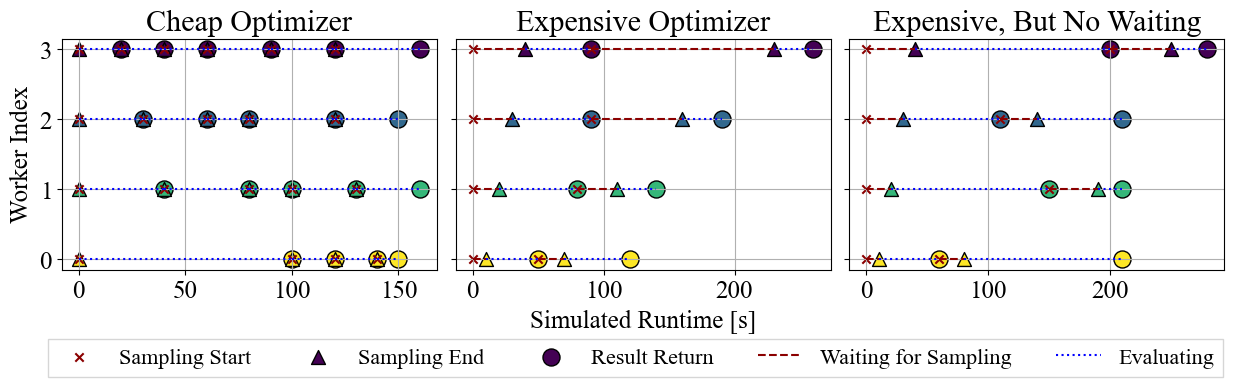

In [18]:
def plot_progress(ax: plt.Axes, target: str, legend: bool = False):
    result = {k: np.asarray(v) for k, v in json.load(open(f"../validation-results/mfhpo-simulator-info/validation-{target}/results.json")).items()}
    sampled_time = {k: np.asarray(v) for k, v in json.load(open(f"../validation-results/mfhpo-simulator-info/validation-{target}/sampled_time.json")).items()}
    cm = plt.get_cmap()
    colors = [cm(i / 3) for i in range(4)][::-1]
    ax.grid()
    lines = [None] * 5

    for worker_id, color in enumerate(colors):
        mask = (result["worker_index"] == worker_id) & (result["cumtime"] < 10 ** 4)
        cumtime = result["cumtime"][mask]
        mask = sampled_time["worker_index"] == worker_id
        n_configs = cumtime.size
        before_sample = sampled_time["before_sample"][mask][:n_configs]
        after_sample = sampled_time["after_sample"][mask][:n_configs]
        lines[2] = ax.scatter(cumtime, np.full(n_configs, worker_id), color=color, edgecolors="black", s=150)
        lines[1] = ax.scatter(after_sample, np.full(n_configs, worker_id), color=color, marker="^", edgecolors="black", s=100)
        lines[0] = ax.scatter(before_sample, np.full(n_configs, worker_id), color="darkred", marker="x")
        lines[3] = ax.hlines([worker_id] * n_configs, before_sample, after_sample, color="darkred", linestyles="dashed")
        lines[4] = ax.hlines([worker_id] * n_configs, after_sample, cumtime, color="blue", linestyles="dotted")

    if legend:
        ax.legend(
            handles=lines,
            loc='upper center',
            labels=["Sampling Start", "Sampling End", "Result Return", "Waiting for Sampling", "Evaluating"],
            fontsize=16,
            bbox_to_anchor=(-0.57, -0.25),  # ここは調整が必要です
            fancybox=False,
            ncol=len(lines)
        )


_, axes = plt.subplots(ncols=3, sharey=True, figsize=(15, 3), gridspec_kw=dict(wspace=0.05))
axes[0].set_yticks(ticks=[0, 1, 2, 3], labels=[f"{i}" for i in range(4)])
axes[1].set_xlabel("Simulated Runtime [s]")
axes[0].set_ylabel("Worker Index")

axes[0].set_title("Cheap Optimizer")
plot_progress(axes[0], target="cheap")

axes[1].set_title("Expensive Optimizer")
plot_progress(axes[1], target="expensive-basic")

axes[2].set_title("Expensive, But No Waiting")
plot_progress(axes[2], target="expensive-no-overlap", legend=True)

plt.savefig("../figs/cumtime-match.pdf", bbox_inches="tight")